## NDBC-Explore 

This notebook will:
 - request metadata about an NDBC station registered in DDS, 
 - list datasets associated with this station and allow you to select one of them, 
 - show dataset variables with a count of non-missing records
 - let you chose a variable to plot
 - optionally, generate a SuAVE (suave.sdsc.edu) visualization for the dataset
 
## Run the cells in sequence to select dataset and variables to plot for the selected station

### 1. Accept document ID from DDS

In [1]:
%%javascript
function getQueryStringValue (key){  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("docID='".concat(getQueryStringValue("documentId")).concat("'"));

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import urllib.request, json
import helpers
from datetime import datetime, date, time
from ipywidgets import widgets  
from IPython import get_ipython
from IPython.display import display
from matplotlib import pylab
from pylab import *
from IPython.display import clear_output

### 2. Retrieve metadata for this document and list associated datasets

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#construct url from variable
cinergi_url = "http://cinergi.sdsc.edu/geoportal/rest/metadata/item/" + docID

#Create dropdown Buttons and generate table
data_dropdown_options = helpers.create_dropdown_data (cinergi_url)
#Create widget with dropdown options from list created above
def f(datasets):
    return datasets
# out = interact(f, notebooks_menu=nb_menu);
out = interact(f, datasets=data_dropdown_options.keys());


A Jupyter Widget

### 3. Get the selected dataset and prepare it for mapping; generate a list of variables in the dataset with counts of measured (not missing) values

In [7]:
chosen_url = data_dropdown_options[out.widget.result]
data = helpers.create_data_from_urls([chosen_url])

# Create Key Values for graph.
graphKeyVals = []

#Run all operations on Data
for i in range(len(data)):
    data[i].fillna('')
    data[i] = helpers.simplify_column_names(data[i])
    data[i] = helpers.createDateTime(data[i])
    graphKeyVals.append( data[i]['date_time'][0].year)
    data[i]['date_time']= data[i]['date_time'].apply(lambda x: x.replace(year= 2012))
#Create dropdown Buttons and generate table
dropdown_options = helpers.create_dropdowns(data)
dropdown_options.append('Choose Variable')

 read file: http://www.ndbc.noaa.gov/view_text_file.php?filename=venf1h1995.txt.gz&dir=data/historical/stdmet/


C:\Users\izaslavsky\Documents\jupyter-cinergi\operations\cinergi\helpers.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_temp['year'] = ("%s%s")%("19",df_temp['year'][0])


"1995 's data (number of variables in each column)"

,year,month,day,hour,WD,WSPD,GST,WVHT,DPD,APD,MWD,BAR,ATMP,WTMP,DEWP,VIS,date_time
0,8495,8495,8495,8495,8495,8495,8493,0,0,0,0,8494,8494,8471,0,0,8495


### 4. Select a variable for charting. Re-run this cell to chart other variables.

Populating the interactive namespace from numpy and matplotlib


C:\Users\izaslavsky\anaconda2\envs\py3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'fft', 'random', 'interactive', 'power', 'info', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


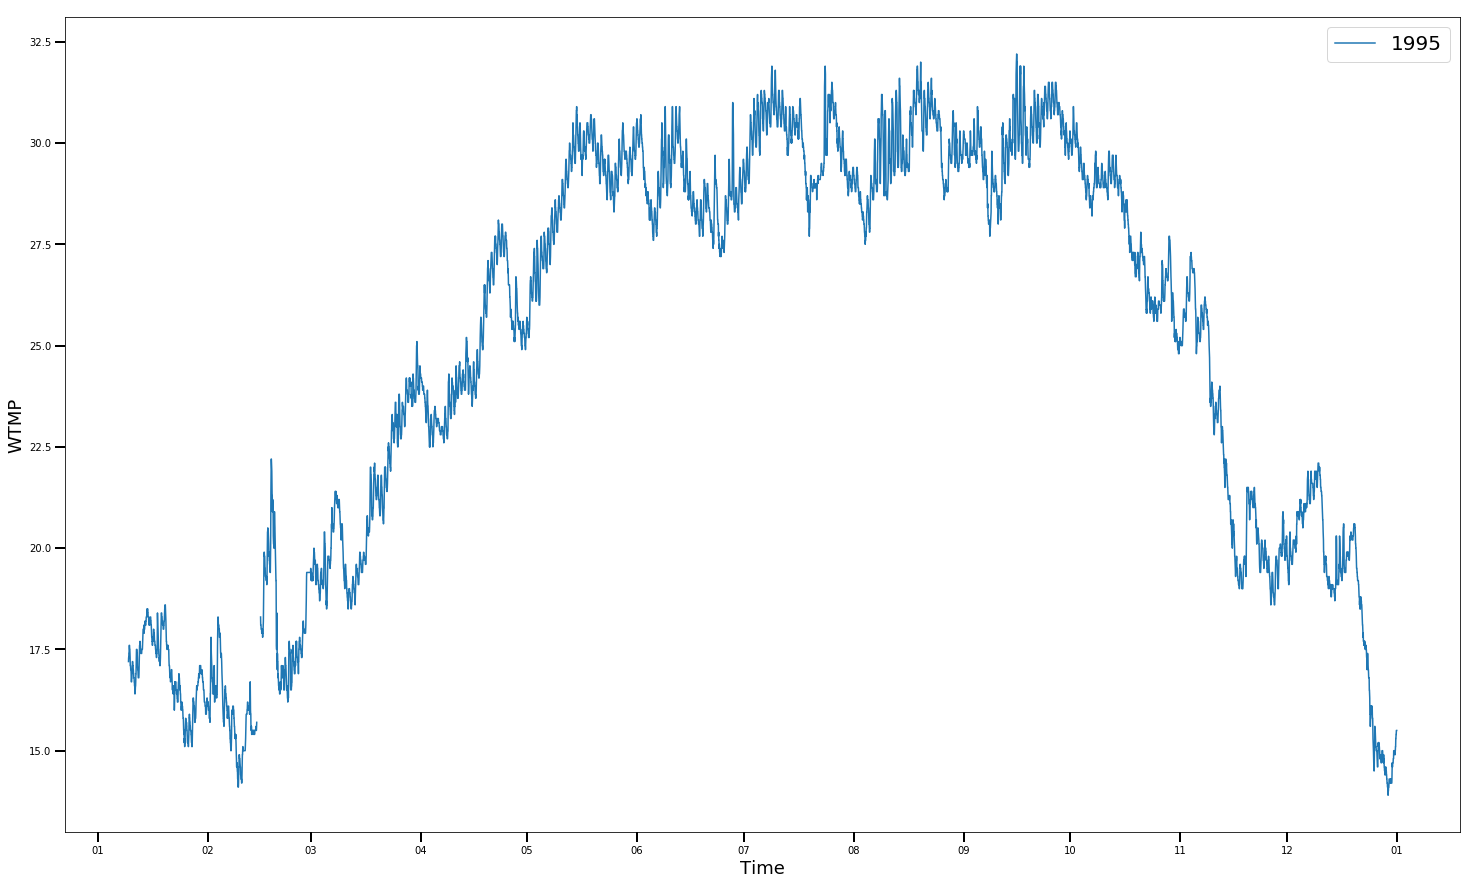

In [8]:
# Example plot of the image based on values of WTMP (Can be changed to other variables)
# rerun this cell if need to plot other variables

#Create widget with dropdown options from list created above
w = widgets.Dropdown(
    options=dropdown_options,
    description='Number:',
    disabled=False,
    value = "Choose Variable"
)

#Describe what happens when the button changes its value
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        %pylab inline
        pylab.rcParams['figure.figsize'] = (25, 15)
        helpers.plotTimeSeriesData(data,change['new'],graphKeyVals)

w.observe(on_change)
display(w)

In [9]:
# TODO: submit usage metadata back to DDH


### 5. Generate a SuAVE survey with the retrieved data?
The survey will be created on suave-dev.sdsc.edu. You need to create a SuAVE account to manage this survey

In [ ]:
#do you want to show it in Suave
suave_dict = {
    'Yes': 1,
    'No': 0,
}

def f(suave_menu):
    return suave_menu

suave_interact_out = interact(f, suave_menu=suave_dict)

print("Do you want to send this dataframe to SuAVE?")

### 6. Enter a name of the SuAVE survey

In [ ]:
if (suave_interact_out.widget.result == 1):

    from IPython.display import display
    input_survey_text = widgets.Text()
    output_survey_text = widgets.Text()


    def bind_input_to_output(sender):
        output_survey_text.value = input_survey_text.value

    # Tell the text input widget to call bind_input_to_output() on submit
    input_survey_text.observe(bind_input_to_output)

    print("Input survey name here:")
    # Display input text box widget for input
    display(input_survey_text)

    display(output_survey_text)

### 7. Enter your SuAVE user name (the survey will be created in your account)

In [ ]:
if (suave_interact_out.widget.result == 1):

    input_user_text = widgets.Text()
    output_user_text = widgets.Text()

    def bind_input_to_output(sender):
        output_user_text.value = input_user_text.value
    
    input_user_text.observe(bind_input_to_output)

    print("Insert user name here:")
    display(input_user_text)
    display(output_user_text)

### 8. Generate the survey with the specified parameters

In [ ]:
import requests
import os
import re
if (suave_interact_out.widget.result == 1):

    survey_name = output_survey_text.value
    user_name = output_user_text.value

    new_file_path = os.path.join("../../temp_csvs", survey_name + ".csv")
    
    new_data = data[0]
    new_data.dropna(axis=1, how='all', inplace=True)

    new_data = new_data.where((pd.notnull(new_data)), '')
    new_data.columns = [str(col) + '#number' for col in new_data.columns]

    
    
    csv_file = new_data.to_csv(new_file_path, index=None)
    upload_url = "http://suave-dev.sdsc.edu:3001/uploadCSV"
    new_survey_url_base = "https://suave-dev.sdsc.edu/main/file="
    

    upload_data = {'name':survey_name, 'dzc':'' ,'user':user_name}
    files = {"file": open(new_file_path, "rb")}
    r = requests.post(upload_url, files=files, data=upload_data)
    print(r.status_code, r.reason)

    regex = re.compile('[^0-9a-zA-Z_]')

    url = new_survey_url_base + user_name + "_" + survey_name + ".csv" + "&views=1110001&view=bucket"
    print(url)
    print ("Click the URL to open the new survey")

